In [2]:
# import all necessary libraries

# for file handling
import os
import time
import scipy
import shutil
# reading files under given folder
import glob
# progress bar
import tqdm
import numpy as np
# plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot
# imaging processing
import skimage as ski
# data processing and manipulation
import pandas as pd
import skimage as ski
import tifffile
from IPython.display import clear_output
%matplotlib inline

import trackpy as tp
import seaborn as sns

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Tracking for a dilute condition


First we will load the dataframe with all bacteria metadata. In the dataframe that we load, we have indices for the time (frame).

In [29]:
# diluted one
#df_track=pd.read_csv("/Users/Clarisse/Downloads/spot_metadata_dilute_500_50_tp.csv")
# dense oneÒ
df_track=pd.read_csv('/Users/Clarisse/Single-bacterium-tracking/data/pilG_dense_PC_metadata_800_800.csv')
df_track.size

12153832

In [30]:
df_track.head()


,Unnamed: 0,frame,x,y,size,orientation,major_axis_length,minor_axis_length
0,0,0,4.230303,8.472727,41.25,0.304692,10.823255,4.971094
1,1,0,5.352423,21.845815,56.75,-0.379875,13.491528,5.450504
2,2,0,7.279197,27.319343,68.50,-0.216216,17.407289,5.236532
3,3,0,7.518272,32.898671,75.25,-0.258081,19.283956,5.270044
4,4,0,2.393130,55.221374,32.75,1.033059,8.170851,5.212592


First we use the link function to assign each particle found in each dataframe to a certain bacteria. This hides a loss function: 

"The tracking algorithm, at its simplest level, takes each particle in the previous frame and tries to find it in the current frame. This requires knowing where to look for it; if we find an actual particle near that spot, it's probably a match. The basic algorithm (Crocker & Grier) was developed to track particles undergoing Brownian diffusion, which ideally means that a particle's velocity is uncorrelated from one frame to the next. Therefore, the best guess for where a particle is going is that it will be near its most recent location." (trackpy documentation)

We choose the average size of the bacteria, here 4 pixels, to optimize the linking function.

In [31]:
t1=tp.link_df(df_track,4)
t1.head()

Frame 300: 5513 trajectories present.


,Unnamed: 0,frame,x,y,size,orientation,major_axis_length,minor_axis_length,particle
0,0,0,4.230303,8.472727,41.25,0.304692,10.823255,4.971094,0
3091,3091,0,541.327273,50.666116,151.25,-0.402784,38.502850,5.211248,1
3090,3090,0,531.085106,706.392097,82.25,0.539706,17.854506,5.917582,2
3089,3089,0,535.415449,505.118998,119.75,-0.028279,27.152764,6.044912,3
3088,3088,0,530.339024,184.834146,51.25,0.185593,13.793010,4.822771,4


Now we will look at what the trajectories look like:

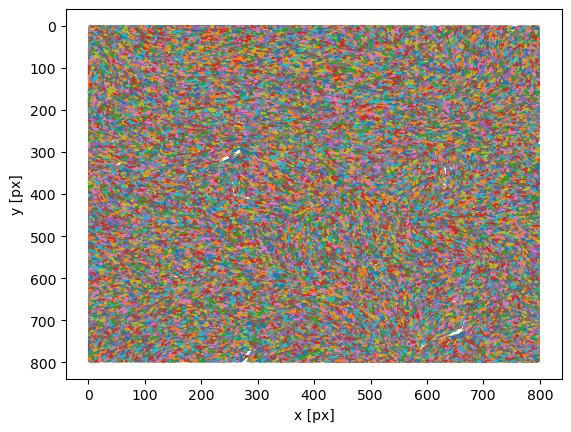

In [32]:
plt.figure()
tp.plot_traj(t1);

There are several long lasting trajectories as well as some single points. You can see in the following cell that the linking algorithm has found more than 900 different trajectories in total. 

In [33]:
t1.particle.unique()

array([     0,      1,      2, ..., 441527, 441528, 441529])

To tackle this issue, we use filter_stubs to get rid of spurious trajectories. We choose a parameter (minimum number of points to be considered) that allows us to be as close as possible to the number of bacteria in the initial frame (118).

In [34]:
t2 = tp.filter_stubs(t1, 10)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t1['particle'].nunique())
print('After:', t2['particle'].nunique())

Before: 441530
After: 29205


In [35]:
t2.head()

,Unnamed: 0,frame,x,y,size,orientation,major_axis_length,minor_axis_length,particle
frame,,,,,,,,,
0,3058,0,528.035316,77.615242,67.25,0.126576,19.295604,4.544410,61
0,3169,0,545.867742,82.733871,77.50,0.361115,18.822048,5.358867,103
0,3146,0,546.569079,393.059211,114.00,-0.021357,28.588330,5.236965,108
0,3116,0,534.133929,610.251116,112.00,1.236094,30.350554,4.838799,120
0,3129,0,540.430966,344.086785,126.75,-0.671490,28.390498,6.009842,125


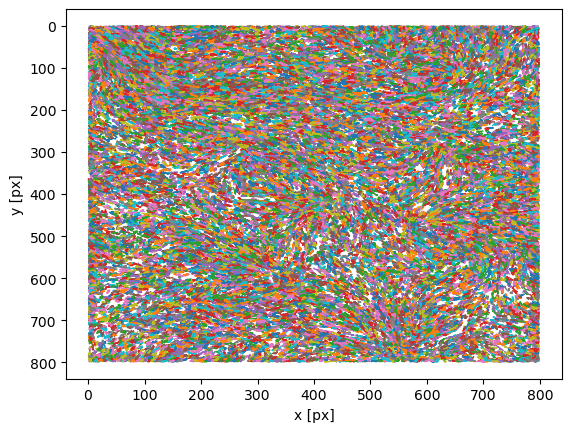

In [36]:
plt.figure()
tp.plot_traj(t2);

We see way less trajectories made only of one point.

In [38]:
plt.savefig('Tracking_img/plot_traj_dense.jpg')

<Figure size 640x480 with 0 Axes>

Another parameter that could interfer with our analysis would be drifting. We look at the drift in both x and y dimensions.

In [ ]:
d = tp.compute_drift(t2)
d.plot()
plt.show()

To get rid of this drift, we use the dedicated function, substract_drift.

In [ ]:

tm = tp.subtract_drift(t2.copy(), d)
ax = tp.plot_traj(tm)
plt.show()

## Analysing the trajectories

*(not sure it's needed, usually used for small particles, Brownian motion)*

1. Mean Squared Displacement of Individal Probes

In [ ]:
im = tp.imsd(tm, 100/285., 24)  # microns per pixel = 100/285., frames per second = 24

In [ ]:
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

2. Ensemble Mean Squared Displacement

In [ ]:
em = tp.emsd(tm, 100/285., 1) # microns per pixel = 100/285., frames per second = 24

fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set(ylim=(1e-2, 10));

In [ ]:
plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$');
tp.utils.fit_powerlaw(em)  # performs linear best fit in log space, plots]


## Extracting metrics from the tracking

There are several metrics we can extract and look at: 
 - the velocity of particles, 
 - the mean orientation, the nematic order 
 - and the number or reversals (or tumbles).

### Nematic order

The nematic order is usually used to describe "the orientational order of the most general biaxial nematic liquid crystal" (Wiki). It is defined in the paper "Large-scale orientational order in bacterial colonies during inward growth, Mustafa Basaran" et al. (2022) as follows:

⟨SR⟩=N1∑i cos[2(θi−φi)]

Where θi is the angular orientation with respect to x-axis and φi is the angular position of the bacterium i in polar coordinates about the colony center

We define theta and phi:

In [ ]:
def theta(data, i):
    if i < len(data):
        theta_i = data['orientation'].iloc[i]
        return theta_i
    else:
        return 0  # Return a default value if the index is out of range

def phi(data, i):
    if i < len(data):
        center = [data.x.mean(), data.y.mean()]
        delta_center = [data.x.iloc[i] - center[0], data.y.iloc[i] - center[1]]
        phi_i = np.arctan2(delta_center[1], delta_center[0])
        return phi_i
    else:
        return 0  # Return a default value if the index is out of range

And we also define the nematic order:

In [ ]:
def nematic_order_over_time(tm_cond,fra):
    SR = []

    for t in fra:
        sub_t = tm_cond[tm_cond.frame == t]

        sr = 0  # Initialize sr for this time step

        for i in range(len(sub_t)):
            sr += np.cos(2 * (theta(sub_t, i) - phi(sub_t, i)))

        SR.append(sr)

    return SR

In [ ]:
# for one condition

time=[t for t in range (0,np.max(df_track.frame)+1)]

N=nematic_order_over_time(tm)
N
plt.plot(time,N)

### Linear and angular velocity

In [ ]:

def velocity(df):

    vel = []
    ori = []

    for part in df.particle.unique():
        tm_part = df[df.particle == part].copy()  # create sub-dataframe for each particle
        tm_part = tm_part.reset_index(drop=True)

        S = 0  # sum of distances traveled
        O = 0  # sum of orientation changes

        prev_x, prev_y, prev_frame = None, None, None  # Initialize previous position and frame

        for index, row in tm_part.iterrows():
            x, y, frame = row['x'], row['y'], row['frame']

            if prev_x is not None and prev_y is not None and prev_frame is not None:
                dist = np.sqrt((x - prev_x) ** 2 + (y - prev_y) ** 2)
                S += dist

                # Calculate orientation change
                O += np.abs(row['orientation'] - tm_part.loc[index - 1, 'orientation'])

            prev_x, prev_y, prev_frame = x, y, frame

        # Calculate the time elapsed for this particle
        total_time = tm_part['frame'].max() - tm_part['frame'].min()

        # Calculate mean velocity and mean orientation change considering time
        if total_time > 0:
            vel.append(S / total_time)
            ori.append(O / total_time)
        else:
            vel.append(0)  # Avoid division by zero
            ori.append(0)

    
    return [vel,ori] # gives a list containing the lists of mean linear and angular velocities of each particle


In [ ]:
velocity(tm)[0]

### Processing 


In [ ]:
def processing(file,condition):

    #read the file, segmentation data
    data=pd.read_csv(file)

    # linking
    t1=tp.link_df(data,4)

    # filtering
    t2 = tp.filter_stubs(t1, 10)

    # removing drift
    d = tp.compute_drift(t2)
    tm = tp.subtract_drift(t2.copy(), d)

    # get metrics from the data
    print('getting metrics')
    frames=data.frame.unique()

    [vel,ori]=velocity(tm)

    part=tm.particle.unique()
    
    #frames=[t for t in range (0,50)]
    # get indices of the bacteria considered

    # create a DataFrame with all the metrics calculated
    print('creating DataFrames')
    table=pd.DataFrame({'particle' : part,
                                'velocity' : vel,
                                'orientation' : ori }, 
                                columns=['particle','velocity', 'orientation'])

    # save metrics in an excel file
    print('saving data to csv')
    
    name=condition + '_metrics.csv'

    table.to_csv('/Users/Clarisse/Single-bacterium-tracking/Data/'+name)

    #return(table)



    

### Do the processing function for all conditions

#### *Check the processing on diluted files*

In [ ]:
processing("/Users/Clarisse/Downloads/spot_metadata_dilute_500_50_tp.csv",'WT_dilute')

#### *Check the processing on dense files*

In [ ]:
processing('/Users/Clarisse/Single-bacterium-tracking/data/pilG_dense_PC_metadata_800_800.csv','WT_dense')

### Processing every videos

We will be repeating the same procedure for all of our dataset (i.e. very videos).

In [ ]:
PATH_big = os.getcwd() + "\\data\\Real\\big_df.csv"

In [ ]:
df_big=pd.read_csv(PATH_big)
df_big.head()

In [ ]:
# We need to swap our x and y values and reverse our y axis values (due to the segmentation algorithm method) to be consistent with our videos
df_big = df_big.rename({"x" : "y", "y" : "x"}, axis=1)
#df_big.y = np.abs(df_big.y - 800)
df_big.head()

In [ ]:
df_big.filename.value_counts()

We will be splicing our big dataframe to track each video separately

In [ ]:
#Get all the filenames
uniqueFiles = df_big.filename.unique()

#create a data frame dictionary to store our data frames
DataFrameDict = {elem : pd.DataFrame() for elem in uniqueFiles}

for key in DataFrameDict.keys():
    DataFrameDict[key] = df_big[:][df_big.filename == key]

In [ ]:
#To access one of our dataframe we can then just use : DataFrameDict["name_of_file"]
DataFrameDict["WT_dense_PC"].head()

Then for the tracking procedure, we will just reuse the steps we showed before :

In [ ]:
TrackingDict = {}

for key in DataFrameDict.keys() :
    t1 = tp.link_df(DataFrameDict[key],4)
    t2 = tp.filter_stubs(t1,10)
    d = tp.compute_drift(t2)
    tm = tp.subtract_drift(t2.copy(), d)
    TrackingDict[key] = tm
    

Now we need to superimpose our trajectories with our raw images :

In [ ]:
# First we need to load the images 
PATH_IMG = os.getcwd() + "\\data\\Real\\output"
# glob the file names in the data directory, keep only the file name not the whole path
DATA_LIST = [os.path.basename(x) for x in glob.glob(os.path.join(PATH_IMG, '*raw_image*'))]
# put DATA_LIST into a pandas dataframe
IMG_DF = pd.DataFrame(DATA_LIST, columns=['filename'])
display(IMG_DF)

In [ ]:
# to access the file names we use :
IMG_DF["filename"][0]

In [ ]:
RESULT_DIR = os.getcwd() + "\\data\\Result"
DATA_DIR = os.getcwd() + "\\data\\Real\\output"

for key in TrackingDict.keys() :
    # we first create a folder for each of our video
    dir = os.path.join(RESULT_DIR,f"{key}")
    if os.path.exists(dir):
        shutil.rmtree(dir)
    os.makedirs(dir)
    
    raw = ski.io.imread(os.path.join(DATA_DIR, f"{key}_raw_image_800_800.tif")) # we open our raw cropped images
    
    for i in range(TrackingDict[key].frame.max()) :# as we want to iterate on every frame
        if i == 0 : #There's no tracking on the first frame so we use the raw image
            ax = plt.imshow(raw[0],cmap=plt.cm.gray)
            ax.get_figure().savefig(dir + f"\\{key}_f{i+1}.png", format="png")
            ax.get_figure().clear() # we clear the current RAM
            plt.close()
            
        else : #all the other frames
            t1 = TrackingDict[key]
            ax = tp.plot_traj(traj=t1[t1.frame<=i],superimpose=raw[i]) # get our raw impose with the tracking superimposed on top
            ax.get_figure().savefig(dir + f"\\{key}_f{i+1}.png", format="png")
            ax.get_figure().clear()
            plt.close() # we clear the current RAM

In [ ]:
#And now we generate a tif file with all of our pngs :
RESULT_DIR = os.getcwd() + "\\data\\Result"
DATA_DIR = os.getcwd() + "\\data\\Real\\output"

for key in TrackingDict.keys() :
    img = []
    for i in range(TrackingDict[key].frame.max()) :# as we want to iterate on every frame
        img.append(mpimg.imread(RESULT_DIR + f"\\{key}" + f"\\{key}_f{i+1}.png"))
    
    ski.io.imsave(os.path.join(RESULT_DIR + f"\\{key}", f'{key}.tif'), np.array(img))


In [ ]:
#We now get the velocities and orientations for every videos :
for key in TrackingDict.keys() :
    frames = TrackingDict[key].frame.unique()
    [vel,ori]=velocity(TrackingDict[key])
    part = TrackingDict[key].particle.unique()
    
    # create a DataFrame with all the metrics calculated
    print('creating DataFrames')
    table=pd.DataFrame({'particle' : part,
                                'velocity' : vel,
                                'orientation' : ori }, 
                                columns=['particle','velocity', 'orientation'])

    # save metrics in an excel file
    print('saving data to csv')
    
    table.to_csv(os.path.join(RESULT_DIR + f"\\{key}", f'{key}_metrics.csv'))  

### Plotting the different metrics for different conditions

In [14]:
# Load data


pilG_dense=pd.read_csv('Tracking_csv/pilG_dense_PC_metrics.csv')
cond=['pilG_dense' for i in range (0,len(pilG_dense))]
pilG_dense['treat']=cond

pilG_dilute=pd.read_csv('Tracking_csv/pilG_dilute_PC_metrics.csv')
cond=['pilG_dilute' for i in range (0,len(pilG_dilute))]
pilG_dilute['treat']=cond

pilH_dense=pd.read_csv('Tracking_csv/pilH_dense_PC_metrics.csv')
cond=['pilH_dense' for i in range (0,len(pilH_dense))]
pilH_dense['treat']=cond

pilH_dilute=pd.read_csv('Tracking_csv/pilH_dilute_PC_metrics.csv')
cond=['pilH_dilute' for i in range (0,len(pilH_dilute))]
pilH_dilute['treat']=cond

WT_dense=pd.read_csv('Tracking_csv/WT_dense_PC_metrics.csv')
cond=['WT_dense' for i in range (0,len(WT_dense))]
WT_dense['treat']=cond

WT_dilute=pd.read_csv('Tracking_csv/WT_dilute_PC_metrics.csv')
cond=['WT_dilute' for i in range (0,len(WT_dilute))]
WT_dilute['treat']=cond


In [26]:
#metrics=pd.concat([pilG_dilute, pilG_dense,pilH_dilute,pilH_dense,WT_dilute,WT_dense], axis=0) 
metrics=pd.concat([WT_dilute,pilG_dilute,pilH_dilute,WT_dense,pilG_dense,pilH_dense], axis=0) 

metrics.head()

,Unnamed: 0,particle,velocity,orientation,treat
0,0,0,1.356783,0.624771,WT_dilute
1,1,2,0.286370,0.013155,WT_dilute
2,2,8,1.185280,0.038277,WT_dilute
3,3,9,1.431040,0.055468,WT_dilute
4,4,10,0.642461,0.209458,WT_dilute


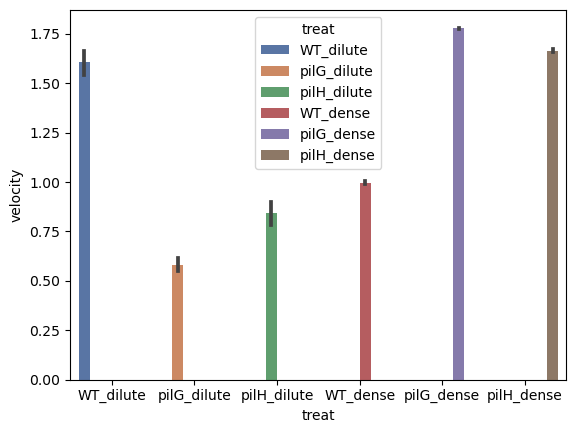

In [27]:
# Barplot for linear velocity
   
sns.barplot(x='treat', y='velocity', hue='treat', palette="deep",data=metrics)

plt.savefig('Tracking_img/velocity.jpg')

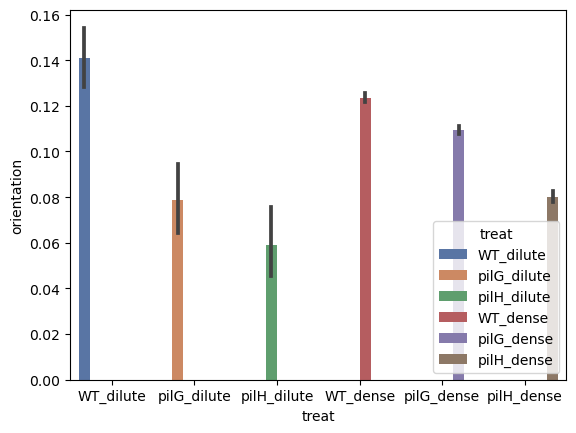

In [28]:
# Barplot for angular velocity

sns.barplot(x='treat', y='orientation', hue='treat', palette="deep",data=metrics)

plt.savefig('Tracking_img/orientation.jpg')